In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# InceptionV3 모델 불러오기
model = InceptionV3(weights="imagenet")

96112376/96112376 [==============================] - 5s 0us/step


In [2]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

In [4]:
import os
import zipfile

# 1) 압축 풀기
local_zip = '/content/raccoon_dog_raccoon.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

(168, 300, 3)


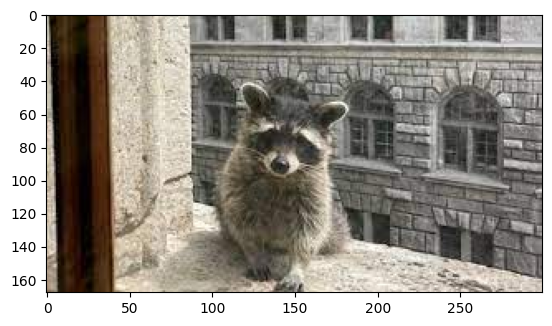

In [5]:
show_image("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

In [6]:

def load_and_process_image(image_path):
    # 이미지의 원래 크기 출력
    print('Original image shape: ', mpimg.imread(image_path).shape)

    # 224x224 크기의 이미지로 로드
    image = image_utils.load_img(image_path, target_size=(299, 299))
    # PIL 형식의 이미지를 NumPy 배열로 변환
    image = image_utils.img_to_array(image)
    # 이미지의 수를 나타내는 차원을 추가 (여기서는 1)
    image = np.expand_dims(image, axis=0)
    # 이미지를 ImageNet 데이터셋에 맞게 전처리
    image = preprocess_input(image)
    # 전처리 후 이미지의 크기 출력
    print('Processed image shape: ', image.shape)
    return image

In [7]:
processed_image = load_and_process_image("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

Original image shape:  (168, 300, 3)
Processed image shape:  (1, 299, 299, 3)


In [8]:
def readable_prediction(image_path):
    # 이미지 보여주기
    show_image(image_path)
    # 이미지 로드 및 전처리
    image = load_and_process_image(image_path)
    # 예측 수행
    predictions = model.predict(image)
    # 예측 결과를 읽을 수 있는 형태로 출력
    print('Predicted:', decode_predictions(predictions, top=3))

(168, 300, 3)
Original image shape:  (168, 300, 3)
Processed image shape:  (1, 299, 299, 3)
35363/35363 [==============================] - 0s 0us/step
Predicted: [[('n01877812', 'wallaby', 0.46362007), ('n02437616', 'llama', 0.08253304), ('n02326432', 'hare', 0.03042007)]]


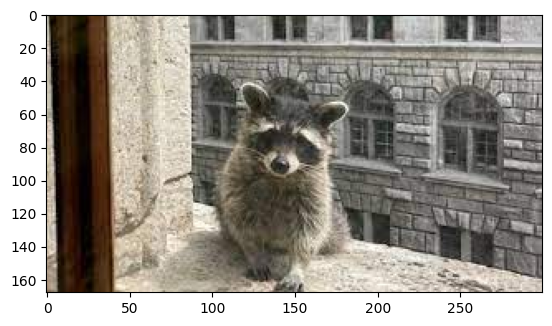

In [9]:
readable_prediction("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

In [10]:
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(
    weights='imagenet',  # ImageNet 데이터셋으로 사전 훈련된 가중치 사용
    input_shape=(224, 224, 3),
    include_top=False)  # Fully connected layers를 포함하지 않습니다.

87910968/87910968 [==============================] - 5s 0us/step


In [11]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalizati

In [12]:
base_model.trainable = False

In [13]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [15]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])


In [16]:
import os
import shutil
import random

# 데이터셋 디렉토리
dataset_dir = '/content/raccoon_dog_raccoon'

# 훈련 데이터와 검증 데이터를 저장할 디렉토리 생성
train_dir = '/content/train_data/'
validation_dir = '/content/validation_data/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# 클래스 목록
classes = ['raccoon', 'raccoon_dog']

# 훈련 데이터와 검증 데이터 비율 설정
train_ratio = 0.9  # 훈련 데이터 비율
validation_ratio = 0.1  # 검증 데이터 비율
random.seed(776) #랜덤시드고정

# 각 클래스에 대해 훈련과 검증 데이터로 나누기
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)  # 이미지 섞기

    # 이미지 개수 계산
    total_images = len(images)
    train_size = int(total_images * train_ratio)

    # 훈련 데이터 복사
    for image in images[:train_size]:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

    # 검증 데이터 복사
    for image in images[train_size:]:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

print("데이터 분리 완료.")

데이터 분리 완료.


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically


In [18]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/train_data',
                                       target_size=(224, 224),
                                       color_mode='rgb',
                                       class_mode='binary',
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('/content/validation_data',
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode='binary',
                                      batch_size=8)

Found 400 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [19]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 11s 306ms/step - loss: 4.6423 - binary_accuracy: 0.5000 - val_loss: 2.4989 - val_binary_accuracy: 0.7188
Epoch 2/20
12/12 [==============================] - 3s 231ms/step - loss: 2.7629 - binary_accuracy: 0.4792 - val_loss: 2.9783 - val_binary_accuracy: 0.5938
Epoch 3/20
12/12 [==============================] - 3s 250ms/step - loss: 3.1508 - binary_accuracy: 0.4688 - val_loss: 5.7488 - val_binary_accuracy: 0.4062
Epoch 4/20
12/12 [==============================] - 3s 231ms/step - loss: 2.6066 - binary_accuracy: 0.5521 - val_loss: 3.5492 - val_binary_accuracy: 0.4688
Epoch 5/20
12/12 [==============================] - 3s 229ms/step - loss: 2.1581 - binary_accuracy: 0.5312 - val_loss: 3.9532 - val_binary_accuracy: 0.5312
Epoch 6/20
12/12 [==============================] - 3s 233ms/step - loss: 2.5074 - binary_accuracy: 0.5833 - val_loss: 2.3449 - val_binary_accuracy: 0.4688
Epoch 7/20
12/12 [==============================] - 3s 230ms/st

In [20]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [21]:
history = model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 28s 375ms/step - loss: 2.2653 - binary_accuracy: 0.5312 - val_loss: 1.2718 - val_binary_accuracy: 0.4062
Epoch 2/20
12/12 [==============================] - 2s 191ms/step - loss: 0.9389 - binary_accuracy: 0.4896 - val_loss: 0.9324 - val_binary_accuracy: 0.4375
Epoch 3/20
12/12 [==============================] - 2s 194ms/step - loss: 0.6438 - binary_accuracy: 0.6250 - val_loss: 0.9633 - val_binary_accuracy: 0.5625
Epoch 4/20
12/12 [==============================] - 3s 233ms/step - loss: 0.6100 - binary_accuracy: 0.7396 - val_loss: 0.8737 - val_binary_accuracy: 0.5625
Epoch 5/20
12/12 [==============================] - 2s 193ms/step - loss: 0.7459 - binary_accuracy: 0.6042 - val_loss: 0.7485 - val_binary_accuracy: 0.5312
Epoch 6/20
12/12 [==============================] - 2s 192ms/step - loss: 0.5969 - binary_accuracy: 0.7083 - val_loss: 0.6640 - val_binary_accuracy: 0.6875
Epoch 7/20
12/12 [==============================] - 2s 198ms/st

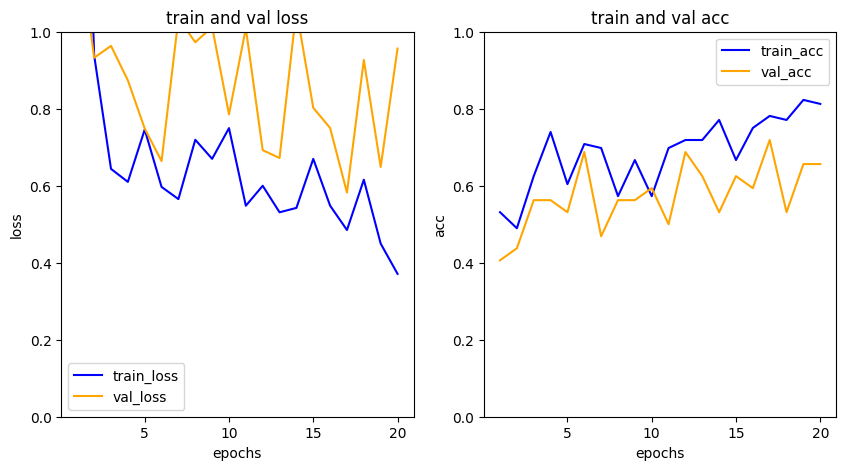

In [22]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['binary_accuracy']
val_acc = his_dict['val_binary_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

plt.show()

In [23]:
model.evaluate_generator(valid_it)#손실 ,정확

<ipython-input-23-bd26194a10c3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(valid_it)#손실 ,정확


[0.8759424686431885, 0.6086956262588501]

In [24]:
model.evaluate_generator(train_it) #손실 ,정확도

<ipython-input-24-cc7f0b0d6f18>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_it) #손실 ,정확도


[0.48382338881492615, 0.7574999928474426]

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 3s 3s/step


array([[-1.3728853]], dtype=float32)

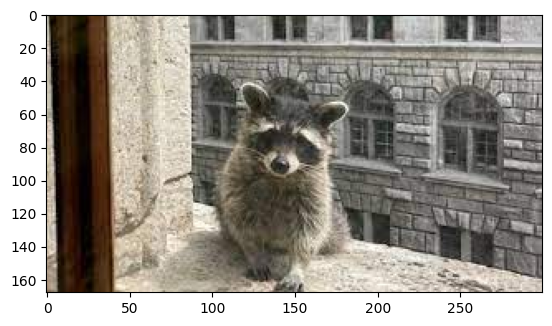

In [26]:
make_predictions('/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg')

1/1 [==============================] - 0s 27ms/step


array([[2.9951282]], dtype=float32)

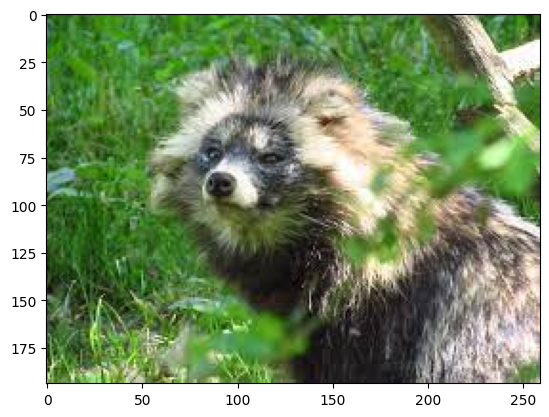

In [27]:
make_predictions('/content/raccoon_dog_raccoon/raccoon_dog/raccoon_dog_1.jpg')

In [28]:
def species(image_path):
    preds = make_predictions(image_path)
    if preds[0] > 0:
        print("It's raccoon_dog!, korean species!")
    else:
        print("It's raccoon! alien species!")


1/1 [==============================] - 0s 27ms/step
It's raccoon! alien species!


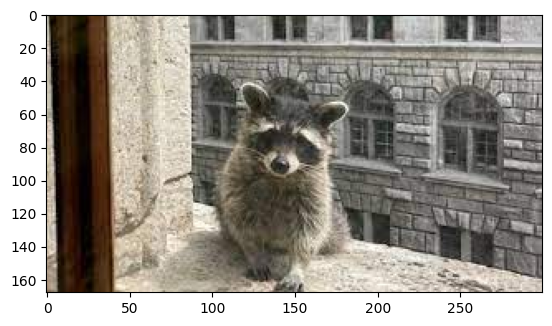

In [29]:
# 예측할 이미지 경로
new_image_path = '/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg'

# 새로운 이미지에 대한 예측 수행
species(new_image_path)

1/1 [==============================] - 0s 30ms/step
It's raccoon_dog!, korean species!


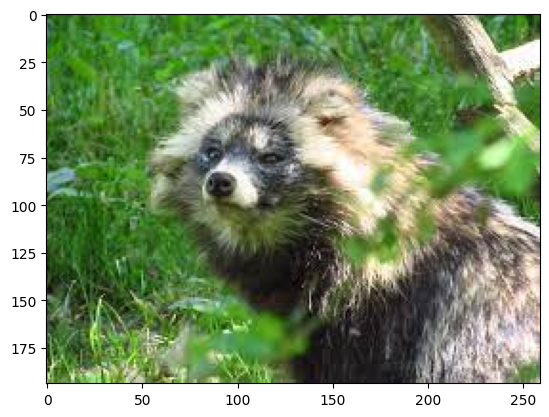

In [30]:
# 예측할 이미지 경로
new_image_path = '/content/raccoon_dog_raccoon/raccoon_dog/raccoon_dog_1.jpg'

# 새로운 이미지에 대한 예측 수행
species(new_image_path)

In [31]:
model.save('/content/inceptionv3_model.keras')